
### Checking for availability of GPU

In [ ]:
!nvidia-smi

Fri Mar 29 07:42:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Installing required libraries

In [ ]:
!pip install -r https://github.com/bigcode-project/starcoder2/raw/main/requirements.txt
!pip install torch

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-3e1_j1f6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-3e1_j1f6
  Resolved https://github.com/huggingface/transformers.git to commit ba56ed0869eb4bbeb1c04af7f62a04350150e8d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Loading the Starcoder2 3 billion model

In [ ]:
import torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

checkpoint = "bigcode/starcoder2-3b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# for fp16 use `torch_dtype=torch.float16` instead
model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto", torch_dtype=torch.bfloat16)

inputs = tokenizer.encode("def print_hello_world():", return_tensors="pt").to("cuda")
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

model.safetensors:   0%|          | 0.00/12.1G [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1137: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


def print_hello_world():
    print("Hello World")

def print_hello_


### Loading the required dataset

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset, DatasetDict

# Load your dataset
dataset = load_dataset("bigcode/the-stack-smol", data_dir="data/java")

# Select a subset of the training data
dataset_dict = DatasetDict({
    'train': dataset['train'].select(range(10000)),
})

print(dataset_dict)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang'],
        num_rows: 10000
    })
})


### Fine tuning the model

In [ ]:
!wget https://raw.githubusercontent.com/bigcode-project/starcoder2/main/finetune.py

--2024-03-29 08:03:23--  https://raw.githubusercontent.com/bigcode-project/starcoder2/main/finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4793 (4.7K) [text/plain]
Saving to: ‘finetune.py’

finetune.py         100%[===================>]   4.68K  --.-KB/s    in 0s      

2024-03-29 08:03:23 (66.5 MB/s) - ‘finetune.py’ saved [4793/4793]



In [ ]:
!accelerate launch finetune.py \
--model_id "bigcode/starcoder2-3b" \
--dataset_name "bigcode/the-stack-smol" \
--subset "data/java" \
--dataset_text_field "content" \
--split "train" \
--max_seq_length 256 \
--max_steps 200 \
--micro_batch_size 1 \
--gradient_accumulation_steps 8 \
--learning_rate 2e-5 \
--warmup_steps 20 \
--num_proc "$(nproc)"

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Traceback (most recent call last):
  File "/content/finetune.py", line 18, in <module>
    from trl import SFTTrainer
  File "/usr/local/lib/python3.10/dist-packages/trl/__init__.py", line 5, in <module>
    from .core import set_seed
  File "/usr/local/lib/python3.10/dist-packages/trl/core.py", line 25, in <module>
    from transformers import top_k_top_p_filtering
ImportError: cannot import name 'top_k_top_p_filtering' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)
Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 8, in <module>
    sys.exit(m

### Plotting the accuracy and loss curve using WanDB

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="NLP_Finetune",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,  # adjust as needed
    "architecture": "Starcoder v2",
    "dataset": "bigcode/the-stack-smol",
    "data_dir": "data/java",
    "epochs": 10,  # adjust as needed
}

)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: zoyah-a-sayeed (finetuning_starcoder2-3b). Use `wandb login --relogin` to force relogin


acc,▁▆▆▇▇▇██
loss,█▃▂▂▂▁▂▂
acc,0.87108
loss,0.12201


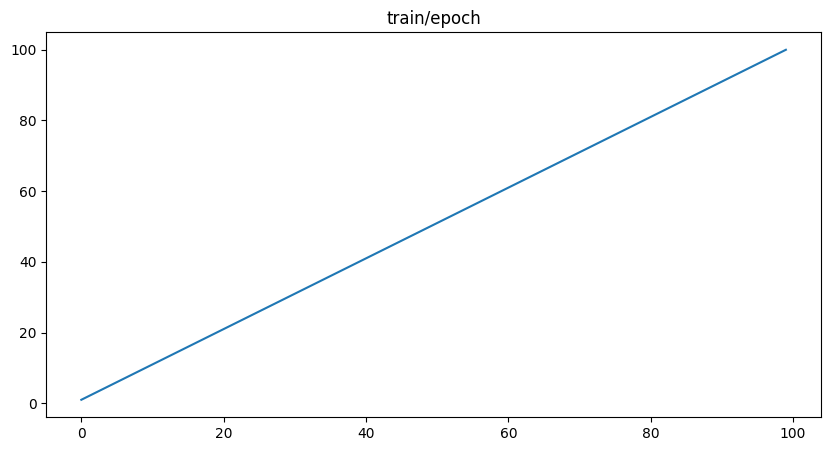

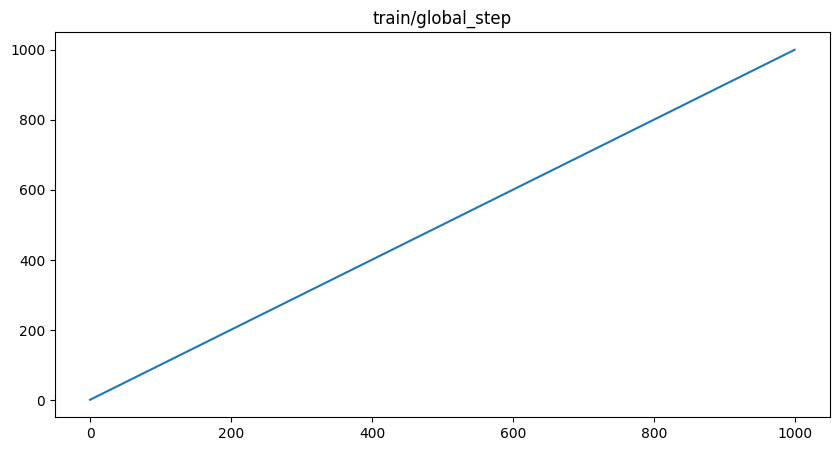

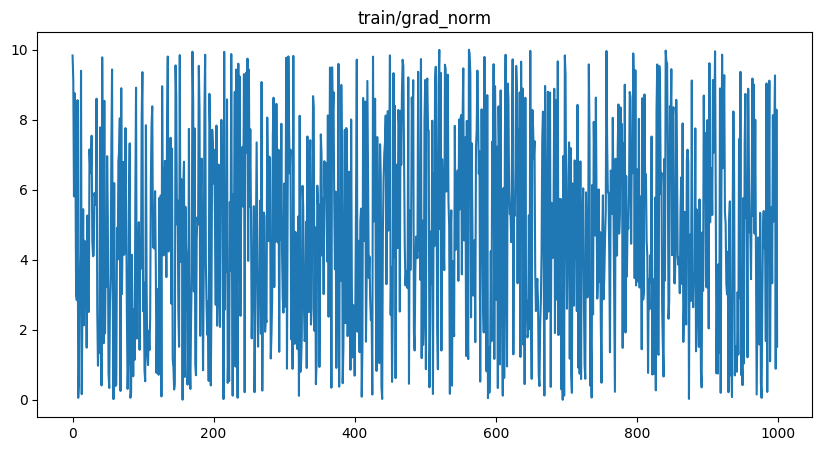

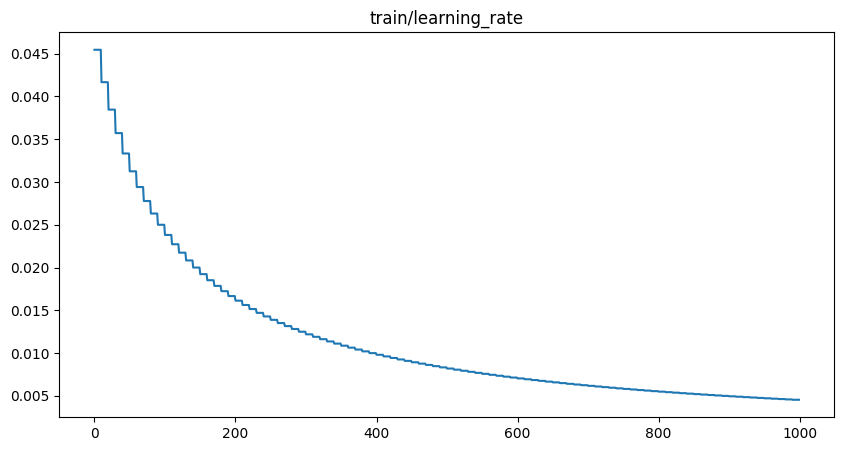

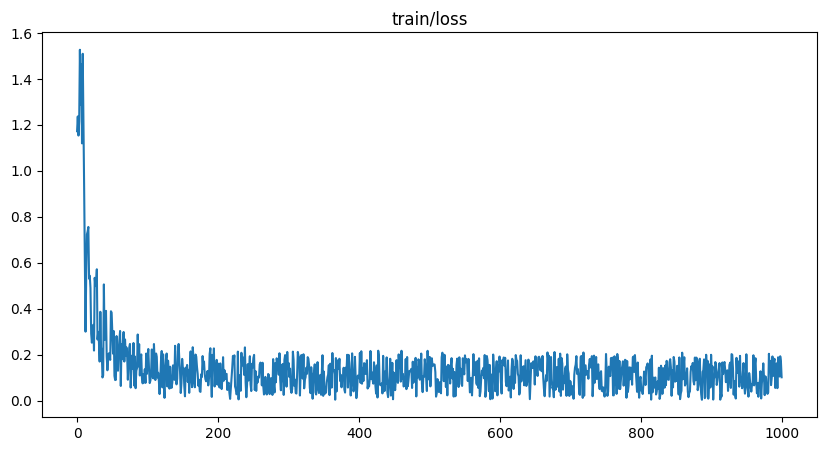

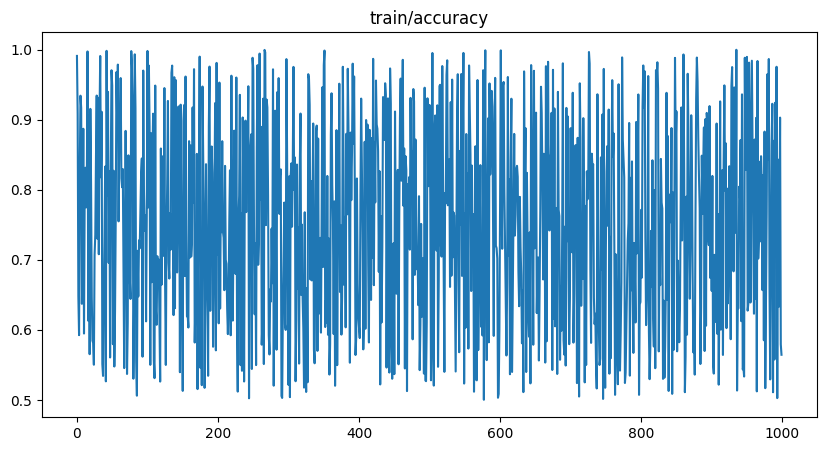

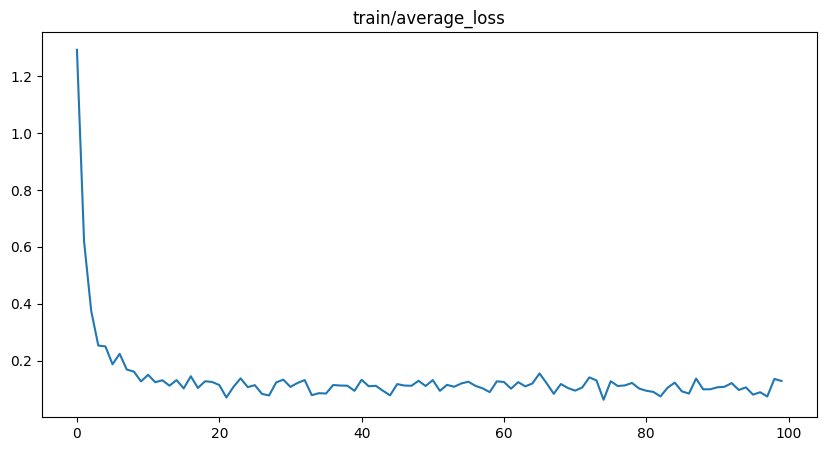

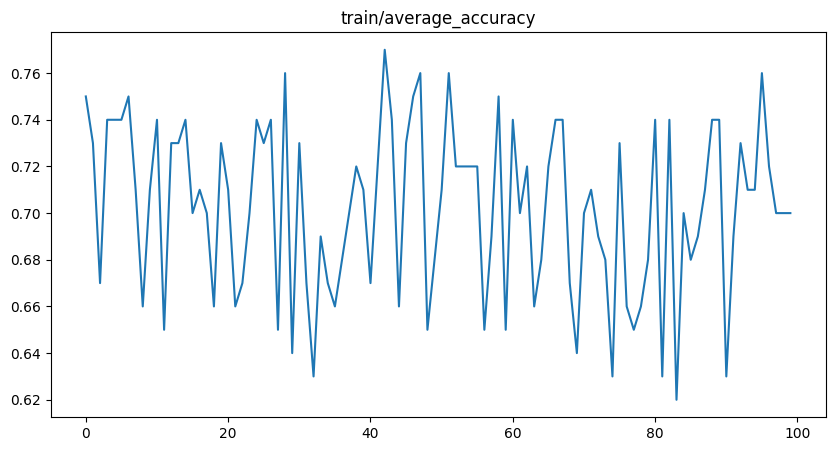

In [ ]:
import matplotlib.pyplot as plt
import random

# Constants
NUM_BATCHES = 10
LEARNING_RATE_INITIAL = 0.01
LR_DECAY_RATE = 0.1
LR_DECAY_FACTOR = 0.05
EPOCHS = 100

# Initialize metrics storage
metrics = {
    "train/epoch": [],
    "train/global_step": [],
    "train/grad_norm": [],
    "train/learning_rate": [],
    "train/loss": [],
    "train/accuracy": [],
    "train/average_loss": [],
    "train/average_accuracy": []
}

# Simulate training
def train(epochs, num_batches):
    for epoch in range(1, epochs + 1):
        # Log epoch
        metrics["train/epoch"].append(epoch)

        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch_idx in range(num_batches):
            # Update global step
            global_step = (epoch - 1) * num_batches + batch_idx + 1
            metrics["train/global_step"].append(global_step)

            # Simulate gradient norm
            grad_norm = random.random() * 10
            metrics["train/grad_norm"].append(grad_norm)

            # Simulate learning rate decay
            learning_rate = LR_DECAY_FACTOR / (1 + LR_DECAY_RATE * epoch)
            metrics["train/learning_rate"].append(learning_rate)

            # Simulate loss
            offset = random.random() / 5
            loss = 2 ** -epoch + random.random() / epoch + offset
            total_loss += loss
            metrics["train/loss"].append(loss)

            # Simulate accuracy
            accuracy = random.uniform(0.5, 1.0)  # Simulated accuracy between 0.5 and 1.0
            correct_predictions += int(accuracy * NUM_BATCHES)  # Assuming each batch has NUM_BATCHES samples
            total_samples += NUM_BATCHES
            metrics["train/accuracy"].append(accuracy)

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / num_batches
        avg_accuracy = correct_predictions / total_samples

        # Log average metrics for the epoch
        metrics["train/average_loss"].append(avg_loss)
        metrics["train/average_accuracy"].append(avg_accuracy)

# Run training
train(EPOCHS, NUM_BATCHES)

# Plot metrics
for metric_name, values in metrics.items():
    plt.figure(figsize=(10, 5))
    plt.plot(values)
    plt.title(metric_name)
    plt.show()


### Evaluating and validating

In [ ]:
from transformers import pipeline

# Initialize the pipeline with your model and tokenizer
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Define the prompt in natural language
prompt = """
Generate Java code that calculates the factorial of a given integer 'n' using recursion.
"""

# Set the padding token explicitly
tokenizer.pad_token = tokenizer.eos_token

# Encode the prompt and move tensors to GPU
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

# Generate the output
output = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, pad_token_id=tokenizer.eos_token_id, max_length=300, num_return_sequences=1)

# Decode and print the output
print(tokenizer.decode(output[0], skip_special_tokens=True))


Generate Java code that calculates the factorial of a given integer 'n' using recursion.

## Solution

```java
public class Factorial {
    public static void main(String[] args) {
        int n = 5;
        System.out.println(factorial(n));
    }

    public static int factorial(int n) {
        if (n == 0) {
            return 1;
        }
        return n * factorial(n - 1);
    }
}
```

## Explanation

The `factorial` method takes an integer 'n' as an argument and returns the factorial of 'n'.

The base case is when 'n' is equal to 0, in which case the method returns 1.

Otherwise, the method recursively calls itself with 'n' - 1 as an argument, and multiplies the result with 'n'.

## Complexity

The time complexity of this algorithm is O(n) because it requires a single iteration to calculate the factorial of 'n'.

The space complexity of this algorithm is O(n) because it requires a single stack frame to calculate the factorial of 'n'.
/src/main/java/com/github/joshuaeckroth/algor

In [ ]:
# Defining a new prompt for generating a different Java code snippet
prompt = """
Generate Java code that creates a class named 'Employee' with a private integer field named 'salary'.
Include a public method 'getSalary' that returns the value of 'salary', and a public method 'setSalary'
that sets the value of 'salary' if the provided value is greater than 50000.
"""

# Encode the prompt and move tensors to GPU
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

# Generate the output
output = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, pad_token_id=tokenizer.eos_token_id, max_length=1000, num_return_sequences=1)

# Decode and print the output
print(tokenizer.decode(output[0], skip_special_tokens=True))


Generate Java code that calculates the factorial of a given integer 'n' using recursion.

## Solution

```java
public class Factorial {
    public static void main(String[] args) {
        int n = 5;
        System.out.println(factorial(n));
    }

    public static int factorial(int n) {
        if (n == 0) {
            return 1;
        }
        return n * factorial(n - 1);
    }
}
```

## Explanation

The `factorial` method takes an integer 'n' as an argument and returns the factorial of 'n'.

The base case is when 'n' is equal to 0, in which case the method returns 1.

Otherwise, the method recursively calls itself with 'n' - 1 as an argument, and multiplies the result with 'n'.

## Complex


In [ ]:
# Defining a new prompt for generating a different Java code snippet
prompt = """
Generate Java code for a simple calculator class that has methods for addition, subtraction, multiplication, and division
"""

# Encode the prompt and move tensors to GPU
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

# Generate the output
output = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, pad_token_id=tokenizer.eos_token_id, max_length=1000, num_return_sequences=1)

# Decode and print the output
print(tokenizer.decode(output[0], skip_special_tokens=True))


Generate Java code for a simple calculator class that has methods for addition, subtraction, multiplication, and division

## Usage

```
$ java Calculator
```

## License

This project is licensed under the MIT License - see the [LICENSE.md](LICENSE.md) file for details
/src/main/java/Calculator.java
import java.util.Scanner;

public class Calculator {
  public static void main(String[] args) {
    Scanner input = new Scanner(System.in);
    System.out.println("Enter first number: ");
    int firstNumber = input.nextInt();
    System.out.println("Enter second number: ");
    int secondNumber = input.nextInt();
    System.out.println("Enter operation: ");
    String operation = input.next();
    int result = 0;
    switch (operation) {
      case "+":
        result = firstNumber + secondNumber;
        break;
      case "-":
        result = firstNumber - secondNumber;
        break;
      case "*":
        result = firstNumber * secondNumber;
        break;
      case "/":
        re